In [33]:
import sys
sys.path.append('../lib/')
from BlackbodyFunctions import *
from scipy.signal import get_window

0.11400392702867283595
0.1140039270276700888
0.11400392700764653655


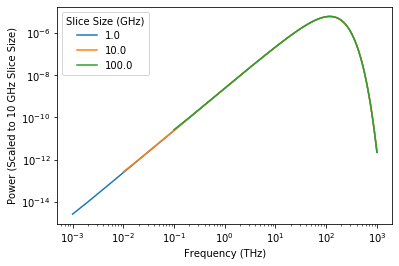

In [53]:
def makePlot(slice_size,useTrap=False):
    freqs = np.arange(slice_size,1e15,slice_size)
    w = blackbodyWeights(freqs,slice_size,useTrap=useTrap)
    plot(freqs*1e-12,w*(1e10/slice_size),label=slice_size*1e-9)
    print(np.sum(w))
    yscale('log')
    xscale('log')
    
for slice_size in [1e9,1e10,1e11]:
    makePlot(slice_size,useTrap=True)
legend(title='Slice Size (GHz)',loc='upper left')
xlabel('Frequency (THz)')
ylabel('Power (Scaled to 10 GHz Slice Size)')
show()

50000.0
0.0 150.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

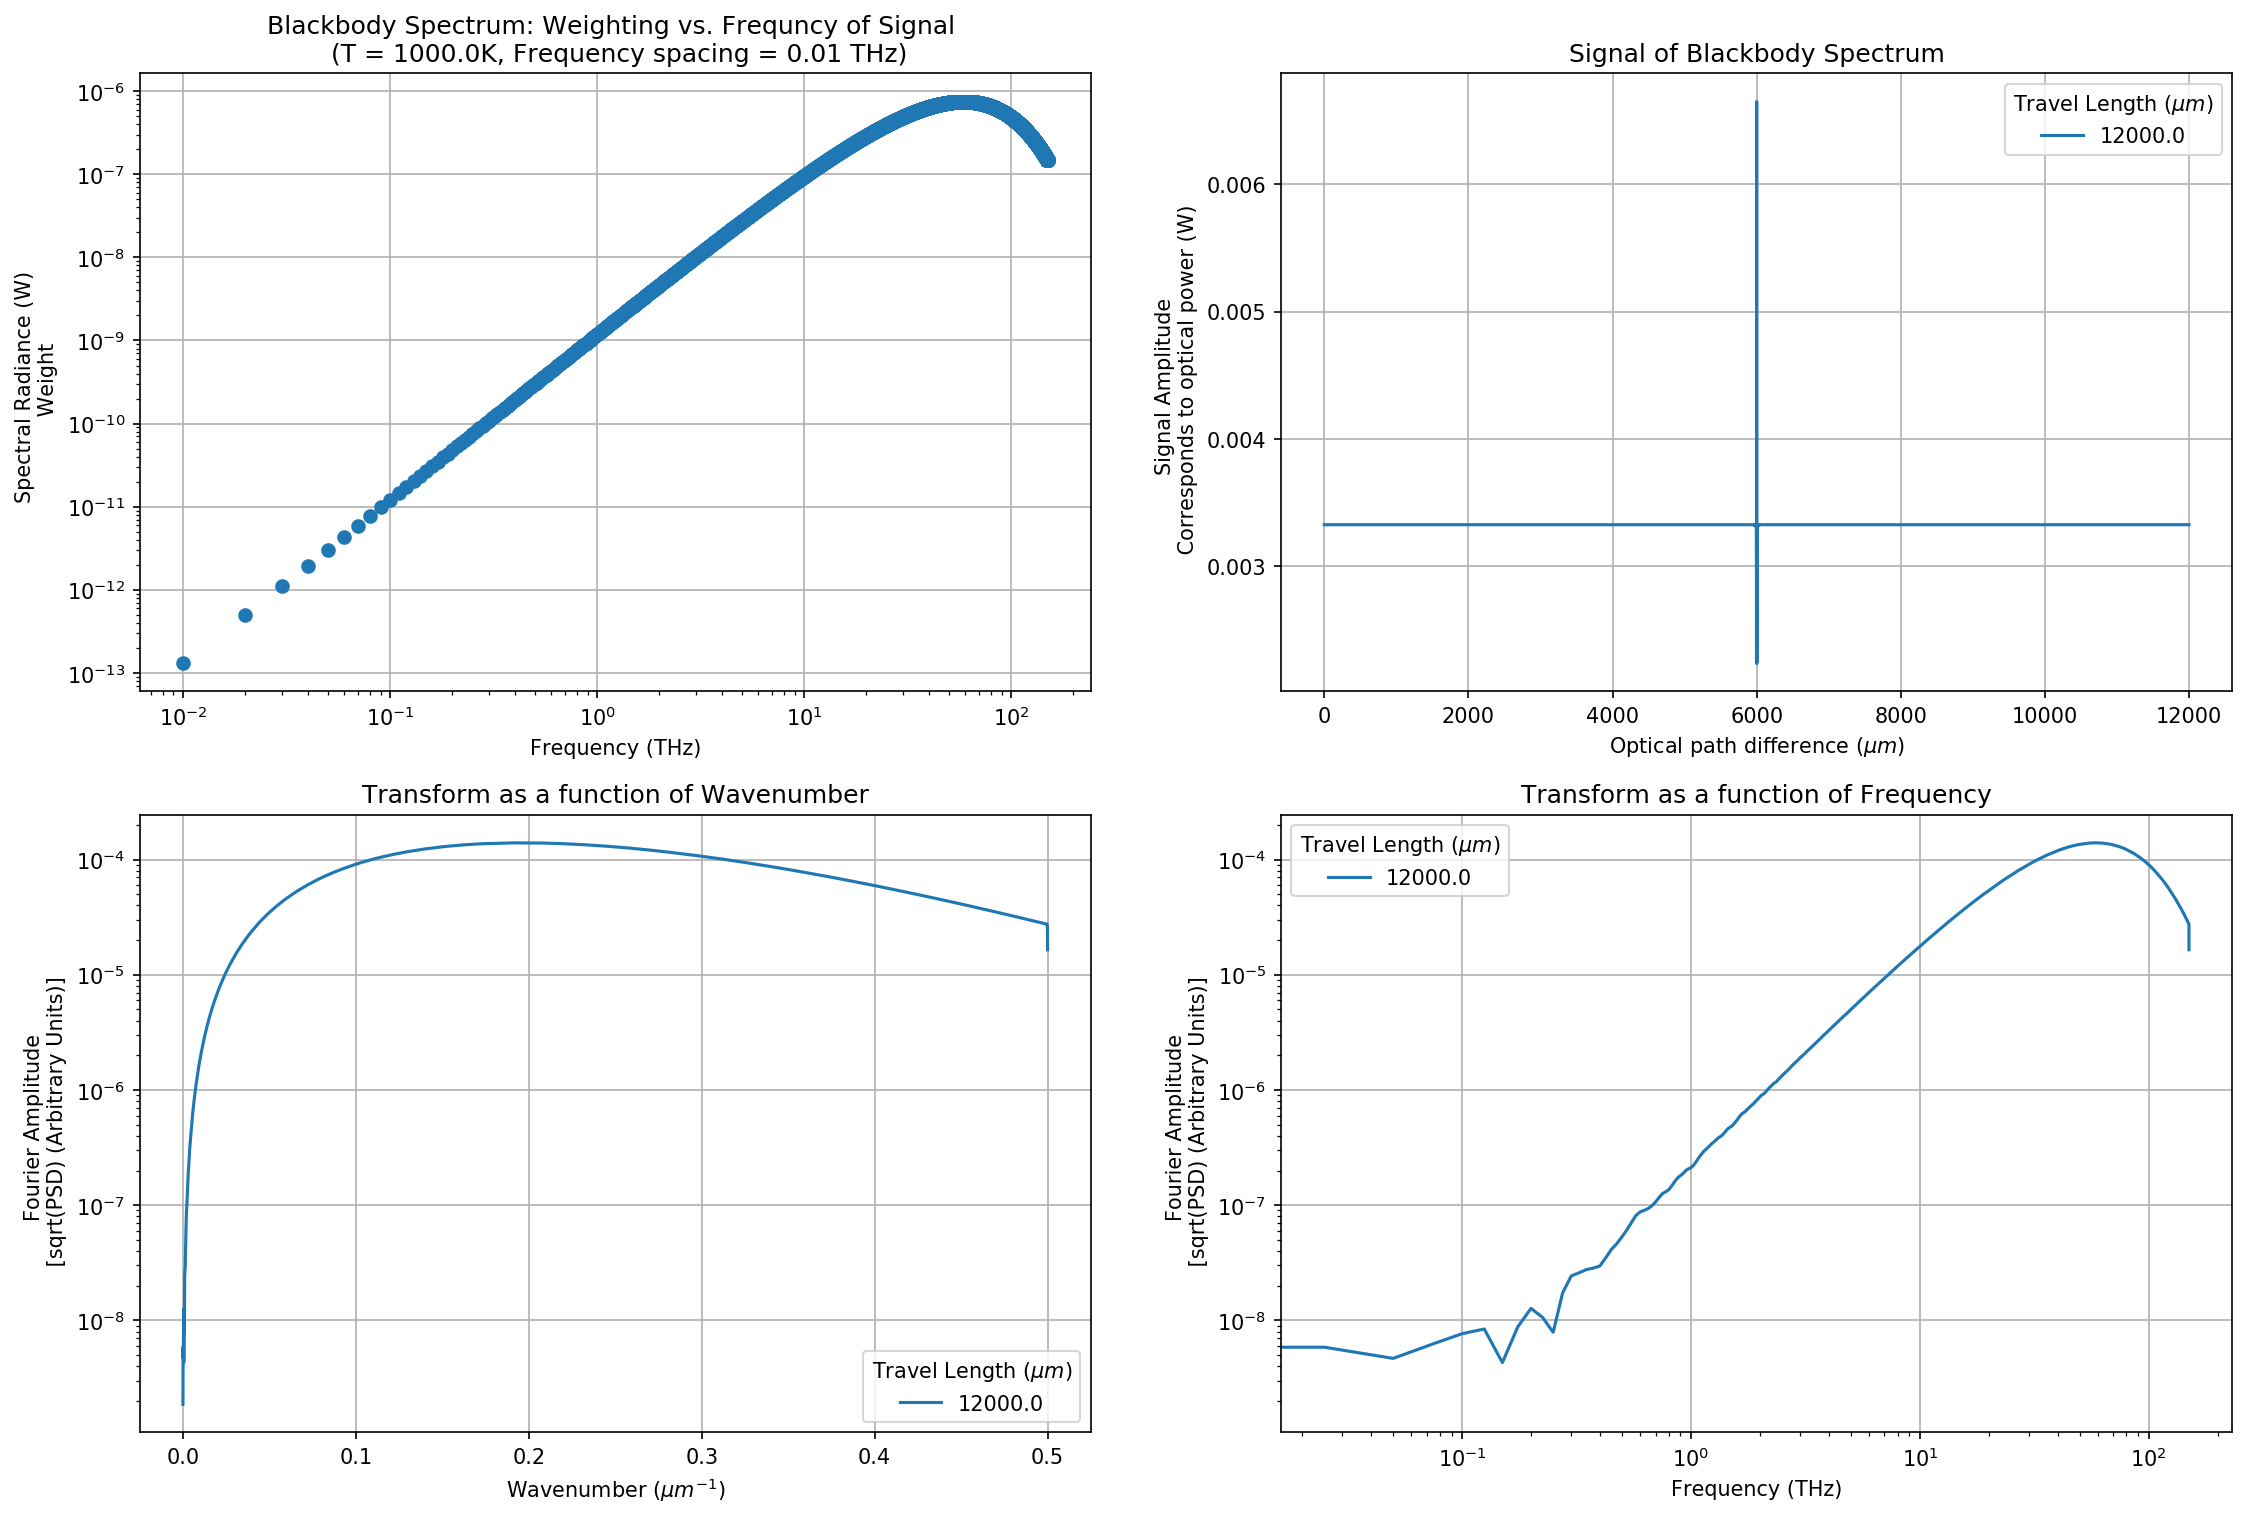

In [111]:
arm_length_1 = 15.0 #cm
arm_length_2 = 10.0 #cm
cm_to_micron = 1e4
dx = abs(arm_length_1-arm_length_2)*cm_to_micron
print(dx)
dx = -6e3

Temp = 1e3 #K

adjustment = 1e-7

dt = 1.0 #micron, step size
fs = 1.0/dt #micron^-1, inv. step size (multiply by h gives energy resolution)
T = 1.2e4 #micron, total travel length
sigma = 2e-8 #noise offset intensity
peaks = []
weights_nofilter = []
c_micron_per_second = 3e8 * 1e6
Hz_to_THz = 1e-12
peak_thershold = 1e-6 #increase this as noise increases, to ensure we are not accidnetally claiming the noise as a peak

fig = plt.figure(figsize=(18, 12), dpi=150)  

#for blackbody spectrum, decide frequeny range and number of frequency slices 
min_frequency = 0.01 #THz
max_frequency = 150 #THz
frequency_slice_size = min_frequency #micron
frequencies = arange(min_frequency, max_frequency, frequency_slice_size) #still in THz

weights_nofilter = blackbodyWeights(frequencies*1e12,frequency_slice_size*1e12,useTrap=True,Temp=Temp)

#This section of code creates the signal
#for nu in frequencies: #(THz)
#  weights_nofilter.append(power_intensity(nu, frequency_slice_size)) # for blackbody, this is the blackbody intensity in W
plt.subplot(2, 2, 1)
plt.plot(frequencies, weights_nofilter , 'o')
xscale('log')

x=np.arange(0,T,dt)
y_phaseNoise = np.zeros_like(x)

for nu in range(len(frequencies)):
  k = frequencies[nu]/(Hz_to_THz*c_micron_per_second) #get wavenumber
  phase = 2.0*pi*dx*k #phase offset depends on wavenumber
  y_phaseNoise += weights_nofilter[nu]*0.5*(np.cos(2.0*pi*k*x + phase)+ 1.0)
y = y_phaseNoise + np.random.rand(len(x))*sigma #create the input signal


plt.subplot(2, 2, 2)
plt.plot(x,y,label= T)

plt.subplot(2, 2, 3)
f_nofilter,p_nofilter = psd(y,fs=fs,window=get_window('parzen',len(y))) #wavenumber, spectrum
plt.semilogy(f_nofilter, np.sqrt(p_nofilter), label=T)
peaks_index, _ = find_peaks(np.log10(np.sqrt(p_nofilter)), prominence=(2.3))
plt.plot(f_nofilter[peaks_index], np.sqrt(p_nofilter[peaks_index]), "x")
peaks.append(f_nofilter[peaks_index])

p_adjusted_nofilter = np.sqrt(p_nofilter) - adjustment
for ps in range(len(p_adjusted_nofilter)):
  if p_adjusted_nofilter[ps] < 0:
    p_adjusted_nofilter[ps] = 0

print(min(f_nofilter)*c_micron_per_second*Hz_to_THz,max(f_nofilter)*c_micron_per_second*Hz_to_THz)
    
plt.subplot(2, 2, 4)
plt.semilogy(f_nofilter*c_micron_per_second*Hz_to_THz, np.sqrt(p_nofilter),label=T)

#plot details for blackbody spectrum plot
plt.subplot(2, 2, 1)
plt.grid(True)
plt.yscale('log')
title = "Blackbody Spectrum: Weighting vs. Frequncy of Signal \n (T = " + str(Temp) + "K, Frequency spacing = "+ str(round(frequency_slice_size,2)) + " THz)"
plt.title(title)
plt.xlabel("Frequency (THz)")
plt.ylabel("Spectral Radiance (W) \n Weight")

#plot details for signal plot
plt.subplot(2, 2, 2)
plt.grid(True)
plt.title("Signal of Blackbody Spectrum")
plt.legend(title="Travel Length ($\mu m$)")
plt.legend(title="Travel Length ($\mu m$)")
plt.xlabel("Optical path difference ($\mu m$)")
plt.ylabel("Signal Amplitude \n Corresponds to optical power (W)")

#plot details for fourier transform plot
plt.subplot(2, 2, 3)
plt.title("Transform as a function of Wavenumber")
plt.grid(True)
plt.legend(title="Travel Length ($\mu m$)")
plt.xlabel('Wavenumber ($\mu m ^{-1}$)')
plt.ylabel("Fourier Amplitude \n [sqrt(PSD) (Arbitrary Units)]")

#plot details for fourier transform plot in terms of frequency rather than wavenumber
plt.subplot(2, 2, 4)
plt.title("Transform as a function of Frequency")
plt.xscale('log')
plt.grid(True)
plt.legend(title="Travel Length ($\mu m$)")
plt.xlabel('Frequency (THz)')
plt.ylabel("Fourier Amplitude \n [sqrt(PSD) (Arbitrary Units)]")
plt.show()

# print("For total travel distance ", Tlist[0], "µm the peaks occur at frequencies:", peaks[0]*c_micron_per_second*Hz_to_THz , "THz")
# print("There are ", len(peaks[0]), " measured peaks")